In [14]:
import os
import pandas as pd
import numpy as np
import time, copy
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from dataloader import EnglishSpanishDataset, train_test_val_split

# Data loading
words_file = os.path.join(os.getcwd(), 'annotations_file.csv')
sentences_file = os.path.join(os.getcwd(), 'pairs.csv')

words_df = pd.read_csv(words_file, header=None)
sentences_df = pd.read_csv(sentences_file, header=None) # use smaller dataset to ease training time

# Train, val and test split
train_set, val_set, test_set = train_test_val_split(sentences_df, 0.8, 0.1, 0.1, random_state=42)

# Define max_sentence_lenght
max_len = 0
for record in sentences_df.to_dict('records'):
    current_len = len(record[0].split(' '))
    if current_len > max_len: max_len = current_len
max_sentence_length = max_len

# Prepare datasets
train_dataset = EnglishSpanishDataset(words_df, train_set, max_sentence_length=max_sentence_length)
val_dataset = EnglishSpanishDataset(words_df, val_set, max_sentence_length=max_sentence_length)
test_dataset = EnglishSpanishDataset(words_df, test_set, max_sentence_length=max_sentence_length)

# Defines batch size and device
batch_size = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


dataloaders = {'train': train_dataloader,
               'val': val_dataloader,
               'test': test_dataloader}

dataset_sizes = {'train': len(train_dataset),
                 'val': len(val_dataset),
                 'test': len(test_dataset)}

class LSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, 
                 vocab_size: int, max_seq_length: int, dropout: float = 0.5):
        super(LSTM, self).__init__()
        
        self.max_seq_length = max_seq_length
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, input_size)
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=2, dropout=dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, input, hidden):
        embedding = self.embedding(input)
        output, hidden = self.rnn(embedding, hidden)
        output = self.fc(output)
        return output, hidden
    
    def initHidden(self, num_layers):
        # We need two hidden layers because of our two layered lstm!
        h0 = torch.zeros(num_layers, self.max_seq_length, self.hidden_size).to(device)
        c0 = torch.zeros(num_layers, self.max_seq_length, self.hidden_size).to(device)
        return (h0, c0)
    



def train_lstm(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # keep the best weights stored separately
    best_loss = np.inf
    best_epoch = 0

    # Each epoch has a training, validation, and test phase
    phases = ['train', 'val', 'test']
    
    # Keep track of how loss evolves during training
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        epoch_start = time.time()

        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data
            for input_sequence, target_sequence in dataloaders[phase]: 
                """
                In a batch size of 10, the dataloader returns 10 examples
                of input and target that both have 30 dimensions. So, each input
                and target batch has (10, 30)
                
                The output of the model will be (10, 30, 39415), which is 
                (batch, sequence_length, n_classes).

                For the loss function, it expects a 2D prediction and a 1D target.
                For the prediction: (batch*sequence_length, n_classes)
                For the target: (batch*sequence_length)

                In this case, we have:
                - predictions: torch.Size([300, 39415])
                - targets:     torch.Size([300])
                """

                # Now Iterate through each sequence here:

                hidden = model.initHidden(num_layers=2) # Start with a fresh hidden state

                current_input_sequence = input_sequence.to(device)
                current_target_sequence = target_sequence.reshape(target_sequence.shape[0]*target_sequence.shape[1]).to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    loss = 0

                    current_hidden = (hidden[0].to(device), hidden[1].to(device))
                    output, hidden = model(current_input_sequence, current_hidden)
                    output = output.reshape(output.shape[0]*output.shape[1], output.shape[2])
                    l = criterion(output, current_target_sequence)
                    loss += l

                    # backward + update weights only if in training phase at the end of a sequence
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() / current_input_sequence.size(0)
 
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)

            print(f'{phase:5} Loss: {epoch_loss:.4f}')

            # deep copy the model if it's the best loss
            # Note: We are using the train loss here to determine our best model
            if phase == 'train' and epoch_loss < best_loss:
              best_epoch = epoch
              best_loss = epoch_loss
              best_model_wts = copy.deepcopy(model.state_dict())

        epoch_time_elapsed = time.time() - epoch_start
        print(f'Epoch complete in {epoch_time_elapsed // 60:.0f}m {epoch_time_elapsed % 60:.0f}s')

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Loss: {best_loss:4f} at epoch {best_epoch}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, training_curves

lstm = LSTM(128, 128, vocab_size=len(train_dataset.words_df), max_seq_length=max_sentence_length).to(device)

learning_rate = 0.001
num_epochs = 10
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Train the model. We also will store the results of training to visualize
word_rnn, training_curves = train_lstm(lstm, dataloaders, dataset_sizes, 
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)



Epoch 1/10
----------
train Loss: 0.0048
val   Loss: 0.0042
test  Loss: 0.0042
Epoch complete in 47m 14s

Epoch 2/10
----------
train Loss: 0.0041
val   Loss: 0.0040
test  Loss: 0.0040
Epoch complete in 46m 33s

Epoch 3/10
----------
train Loss: 0.0040
val   Loss: 0.0040
test  Loss: 0.0040
Epoch complete in 46m 20s

Epoch 4/10
----------
train Loss: 0.0039
val   Loss: 0.0039
test  Loss: 0.0039
Epoch complete in 46m 15s

Epoch 5/10
----------
train Loss: 0.0039
val   Loss: 0.0039
test  Loss: 0.0039
Epoch complete in 47m 20s

Epoch 6/10
----------
train Loss: 0.0038
val   Loss: 0.0039
test  Loss: 0.0039
Epoch complete in 46m 48s

Epoch 7/10
----------
train Loss: 0.0038
val   Loss: 0.0039
test  Loss: 0.0039
Epoch complete in 46m 28s

Epoch 8/10
----------
train Loss: 0.0038
val   Loss: 0.0039
test  Loss: 0.0039
Epoch complete in 46m 29s

Epoch 9/10
----------
train Loss: 0.0038
val   Loss: 0.0039
test  Loss: 0.0039
Epoch complete in 46m 34s

Epoch 10/10
----------
train Loss: 0.0038
val

In [ ]:
torch.save(word_rnn.state_dict(), "next_english_word.model")

In [16]:
def predict(model, input_sentence, max_length = 20):
  output_sentence = input_sentence + " "
  input_tensor, target_tensor = train_dataset.create_input_and_target_tensor(input_sentence)
  h0 = torch.zeros(2, 128).to(device)
  c0 = torch.zeros(2, 128).to(device)
  hidden = (h0, c0)
  # hidden = word_rnn.initHidden(num_layers=2)
  current_input_sequence = torch.reshape(input_tensor, (-1,1)).to(device)
  input = None

  for i in range(current_input_sequence.size(0)):
    output, hidden = word_rnn(current_input_sequence[i], hidden)

  output_tensor = [int(value) for value in input_tensor]
  output_tensor.append(int(output.argmax()))  
  print(output_tensor)
  print(train_dataset.tensor_to_sentence(output_tensor))
  return output_tensor

In [65]:
input_sentence = "i'm looking"
output_tensor = predict(word_rnn.to(device), input_sentence)

[156, 3359, 2851]
i'm looking forward


In [66]:
input_sentence = "look"
output_tensor = predict(word_rnn.to(device), input_sentence)

[668, 1742]
look at


In [67]:
input_sentence = "stop"
output_tensor = predict(word_rnn.to(device), input_sentence)

[35, 39414]
stop <EOS>


In [68]:
input_sentence = "speak"
output_tensor = predict(word_rnn.to(device), input_sentence)

[687, 2421]
speak french


In [18]:
import matplotlib.pyplot as plt

def plot_training_curves(training_curves, 
                         phases=['train', 'val', 'test'],
                         metrics=['loss']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                plt.plot(epochs, training_curves[key])
        plt.xlabel('epoch')
        plt.legend(labels=phases)

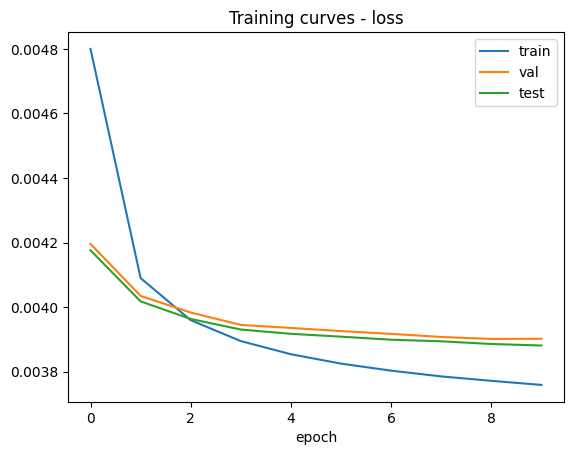

In [19]:
plot_training_curves(training_curves, phases=['train', 'val', 'test'])